##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
pip install remotezip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7947 sha256=6e183c52acc8e4f71d78a019cf10a0df4406e33f2b0eea02c2cb4c2a8a4f7fbd
  Stored in directory: /root/.cache/pip/wheels/36/69/50/7b5a7fd4fda1cbb85c080b1c05cbbd2f88ac6a665260910b13
Successfully built remotezip


In [3]:
%%capture
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official

In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model


## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [45]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [46]:
!unzip "/content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/Zip/BiPS.zip" 

Archive:  /content/drive/MyDrive/Đồ án DS201 - Deep Learning/[1] Data/Data train model 2 label/Zip/BiPS.zip
replace content/BiPS/test/Abnormal/video_4811.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [47]:
subset_paths = {"train": pathlib.Path('/content/content/BiPS/train/'),
                "test": pathlib.Path('/content/content/BiPS/test/'),
                "val": pathlib.Path('/content/content/BiPS/val/')}

In [48]:
subset_paths 

{'train': PosixPath('/content/content/BiPS/train'),
 'test': PosixPath('/content/content/BiPS/test'),
 'val': PosixPath('/content/content/BiPS/val')}

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [49]:
batch_size = 8
num_frames = 10

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], num_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

In [50]:
frames, label = next(iter(train_ds))
label

<tf.Tensor: shape=(8,), dtype=int16, numpy=array([1, 1, 1, 0, 1, 1, 1, 0], dtype=int16)>

In [51]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())
label_names

['Abnormal', 'Normal']

In [52]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1, 10, 8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once

In [53]:
first_half, state = gru(inputs[:, :5, :])   # run the first half, and capture the state
second_half, _ = gru(inputs[:,5:, :], initial_state=state)  # Use the state to continue where you left off.

print(np.allclose(result[:, :5,:], first_half))
print(np.allclose(result[:, 5:,:], second_half))

True
True


In [69]:
model_id = 'a0'
resolution = 172

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [70]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [71]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 8)

In [72]:
num_epochs = 5

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

In [73]:
download_dir=pathlib.Path('/content/content/BiPS/')
video_count_train = len(list(download_dir.glob('train/*/*.mp4')))
video_count_val = len(list(download_dir.glob('val/*/*.mp4')))
video_count_test = len(list(download_dir.glob('test/*/*.mp4')))
video_total = video_count_train + video_count_val + video_count_test
video_count_train

3414

In [74]:
train_steps = video_count_train // batch_size
total_train_steps = train_steps * num_epochs
val_steps = video_count_val // batch_size

In [80]:
model1=model

In [81]:
model.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, None  0         
                             , 3)]                               
                                                                 
 movinet (Movinet)           ({'stem': (None, None, N  911583    
                             one, None, 8),                      
                              'block0_layer0': (None,            
                              None, None, None, 8),              
                              'block1_layer0': (None,            
                              None, None, None, 32),             
                              'block1_layer1': (None,            
                              None, None, None, 32),             
                              'block1_layer2': (None,            
                              None, None, None

In [82]:
results = model1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=3,
                    validation_steps=val_steps,
                    verbose=1)

Epoch 1/3
427/427 [==============================] - 3975s 9s/step - loss: 0.5853 - accuracy: 0.6889 - val_loss: 0.5735 - val_accuracy: 0.6910
Epoch 2/3
427/427 [==============================] - 3842s 9s/step - loss: 0.5394 - accuracy: 0.7162 - val_loss: 0.5504 - val_accuracy: 0.7193
Epoch 3/3
427/427 [==============================] - 3857s 9s/step - loss: 0.5291 - accuracy: 0.7250 - val_loss: 0.5637 - val_accuracy: 0.7099


In [104]:
model1.save("/content/drive/MyDrive/movinet_4_3/movinet.h5")

In [83]:
model1.summary()

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, None  0         
                             , 3)]                               
                                                                 
 movinet (Movinet)           ({'stem': (None, None, N  911583    
                             one, None, 8),                      
                              'block0_layer0': (None,            
                              None, None, None, 8),              
                              'block1_layer0': (None,            
                              None, None, None, 32),             
                              'block1_layer1': (None,            
                              None, None, None, 32),             
                              'block1_layer2': (None,            
                              None, None, None

In [84]:
model1.evaluate(test_ds, return_dict=True)

54/54 [==============================] - 420s 8s/step - loss: 0.5635 - accuracy: 0.7026


{'loss': 0.5634880065917969, 'accuracy': 0.7025761008262634}

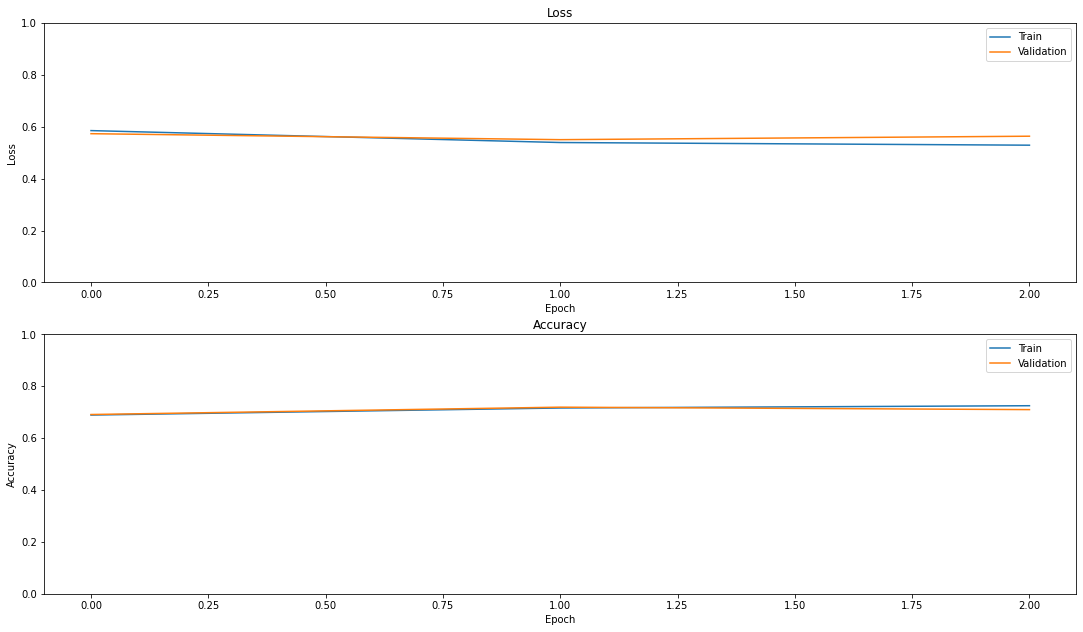

In [85]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(results)

In [86]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model1.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [87]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [88]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

54/54 [==============================] - 423s 8s/step


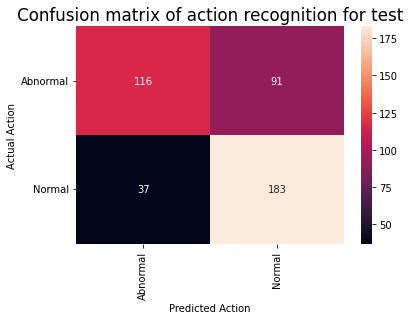

In [89]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')

In [100]:
predicted

<tf.Tensor: shape=(427,), dtype=int64, numpy=
array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
     

In [99]:
actual

<tf.Tensor: shape=(427,), dtype=int16, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [90]:
from sklearn.metrics import classification_report
print(classification_report(actual, predicted,digits=4))

              precision    recall  f1-score   support

           0     0.7582    0.5604    0.6444       207
           1     0.6679    0.8318    0.7409       220

    accuracy                         0.7002       427
   macro avg     0.7130    0.6961    0.6927       427
weighted avg     0.7117    0.7002    0.6941       427



In [103]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
print("acc: ", accuracy_score(actual,predicted))
print("f1: ", f1_score(actual,predicted, average='macro'))
print("pre: ", recall_score(actual,predicted, average='macro'))
print("recall: ", precision_score(actual,predicted,average='macro'))


acc:  0.7002341920374707
f1:  0.6926675663517768
pre:  0.6961023276240668
recall:  0.7130265731596774


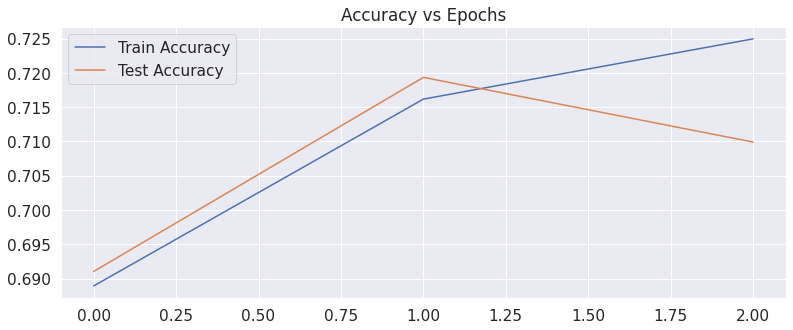

In [91]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [92]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)

In [106]:
from tensorflow import keras
model_test = keras.models.load_model("/content/drive/MyDrive/movinet_4_3/movinet.h5", custom_objects=)

ValueError: ignored